In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
import IPython.display as ipd
from scipy.signal import butter

import warnings
warnings.filterwarnings("ignore")

filename_1 = 'videoplayback.m4a'
filename_2 = 'videoplayback1.m4a'

# Helper functions

In [2]:
def stream(block_size, data, sr, duration):
    block_start = np.arange(0, int(duration), step=block_size) * sr
    block_end = block_start[1::]
    for i, j in zip(block_start, block_end):
        y_block = data[i:j]
        yield y_block / y_block.max()
        

def extract_phonemes(voiced_flag):
    word, words = [], []
    for i, j in enumerate(voiced_flag):
        if j == True:
            word.append(i)
        else:
            if word != []:
                words.append(word)
            word = []
    return words


def extract_stats(phonemes, times, f0):
    stats = {}
    idx, mean, std = [], [], []
    for i, phoneme in enumerate(phonemes):
        mag = [f0[idx] for idx in phoneme]
        mean.append(np.mean(mag))
        std.append(np.std(mag))
        idx.append(i)
    stats['index'] = idx
    stats['mean'] = mean
    stats['std'] = std
    return stats


def frames_to_samples(phoneme, hop_length):
    start_idx = librosa.frames_to_samples(
        phoneme[0], hop_length=hop_length, n_fft=2048)
    end_idx = librosa.frames_to_samples(
        phoneme[-1], hop_length=hop_length, n_fft=2048)
    return start_idx, end_idx


def plotter(filename, block_size, block):
    data, sr = librosa.load(filename, sr=librosa.get_samplerate(filename))
    duration = librosa.get_duration(data, sr=sr)
    fmin = librosa.note_to_hz('G2')
    fmax = librosa.note_to_hz('A4')
    frame_length = 2048
    hop_length = frame_length // 4
    
    print(f'Sample rate: {sr} Hz')
    print(f'Total duration: {duration:.2f}s')
    print(f"Block size: {block_size}s")
    print(f"fmin: {fmin:.2f} Hz")
    print(f"fmax: {fmax:.2f} Hz")
    
    y = list(stream(
        block_size=block_size, data=data, sr=sr, duration=duration))[block]
    
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length*2)[0]
    rms = librosa.feature.rms(y)[0]

    f0, voiced_flag, voiced_prob = librosa.pyin(
        y, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length,
        switch_prob=1e-10, no_trough_prob=1e-2, resolution=2e-1,
        fill_na=np.nan)

    f0 = np.where(
        (voiced_flag==True) & (rms<rms.mean()) & (zcr<zcr.mean()), 
        np.nan, f0)

    voiced_flag = np.where(
        (voiced_flag==True) & (rms<rms.mean()) & (zcr<zcr.mean()), 
        False, voiced_flag)
        
    voiced_ratio = voiced_flag.sum() / len(voiced_flag)
    phonemes = extract_phonemes(voiced_flag)
    print(zcr.mean())
    print("Phonemes detected:", len(phonemes))
    print("voiced_ratio: {:.2f}%".format(voiced_ratio*100))

    times = np.linspace(0, librosa.get_duration(y, sr=sr), num=len(f0))

    S = librosa.stft(y, n_fft=2048, center=False)
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    M = librosa.feature.melspectrogram(y, sr=sr, center=False)
    M_db = librosa.power_to_db(M)

    # Plotting
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 1, height_ratios=[7, 3])
    ax1, ax2 = [plt.subplot(gs[i]) for i in range(2)]

    img2 = librosa.display.waveplot(y, sr=sr, ax=ax2)
    ax2.plot(times, zcr, color='red', label='zcr')
    ax2.plot(times, rms, color='orange', label='rms')
    ax2.set(title='wave form')
    ax2.set_ylim(-1, 1)
    ax2.legend(loc='upper left')
    ax2.set_facecolor("lightgrey")

    img = librosa.display.specshow(
        D, sr=sr, x_axis='time', y_axis='linear', ax=ax1)
    ax1.set(title='spectrogram')
    fig.colorbar(
        img, ax=ax1, pad=0.1, fraction=0.05, 
        orientation='horizontal', format="%+2.f dB")
    ax1.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax1.set_ylim(0, fmax)
    ax1.legend(loc='upper left')

    for i, phoneme in enumerate(phonemes):
        start_idx, end_idx = phoneme[0], phoneme[-1]
        for idx in [start_idx, end_idx]:
            frame = times[idx]
            ax2.vlines(
                x=frame, ymin=-1, ymax=1, colors='green', linestyles='dotted')
        ax2.text(x=times[start_idx], y=-0.4, s=str(i))
        ax2.axvspan(
            xmin=times[start_idx], xmax=times[end_idx], 
            ymin=-1, ymax=1, alpha=0.1, color='green')

    plt.show()
    
    return y, sr, phonemes, times, hop_length, f0


class Algorithm():
    def __init__(self, filename, block_size):
        self.data, self.sr = librosa.load(
            filename, sr=librosa.get_samplerate(filename))
        self.duration = librosa.get_duration(self.data, sr=self.sr)
        self.fmin = librosa.note_to_hz('G2')
        self.fmax = librosa.note_to_hz('A4')
        self.frame_length = 2048
        self.hop_length = self.frame_length // 4
        self.block_size = block_size
        self.n_blocks = int(self.duration // self.block_size)
        self.residual = 0
        self.benchmark = 0
        self.forward = 0
        self.mag_rate = 0.1
        self.grad_limit = 1.0

    
    def train(self):
        for i, y_block in enumerate(
                stream(
                    block_size=self.block_size, data=self.data,
                    sr=self.sr, duration=self.duration)):
            total = 0
            start_time = time.time()
            f0, voiced_flag, voiced_prob = librosa.pyin(
                y_block, sr=self.sr, fmin=self.fmin, fmax=self.fmax,
                frame_length=self.frame_length, switch_prob=1e-10,
                no_trough_prob=1e-2, resolution=2e-1, fill_na=np.nan)

            zcr = librosa.feature.zero_crossing_rate(y_block, frame_length=self.frame_length*2)[0]
            rms = librosa.feature.rms(y_block)[0]

            f0 = np.where(
                (voiced_flag==True) & (rms<rms.mean()) & (zcr<zcr.mean()), 
                np.nan, f0)

            voiced_flag = np.where(
                (voiced_flag==True) & (rms<rms.mean()) & (zcr<zcr.mean()), 
                False, voiced_flag)

            voiced_sum = voiced_flag.sum()

            if voiced_sum == 0:
                print("{}/{} - No speech detected.".format(i+1, self.n_blocks))
                pass
            else:
                phonemes = extract_phonemes(voiced_flag)
                for j, phoneme in enumerate(phonemes):
                    start_idx, end_idx = phoneme[0], phoneme[-1]
                    length = end_idx - start_idx
                    mean = np.mean(f0[start_idx:end_idx])
                    delta = np.abs(mean - self.residual)
                    if length > 1:
                        grad = np.abs(np.mean(np.gradient(f0[start_idx:end_idx], edge_order=1)))
                    else:
                        grad = 1
                    if self.forward == 0:
                        self.buffer = len(phonemes) // 4
                    if ((self.forward == 0) & (j < self.buffer)) | (delta > self.benchmark * 0.3):
                        self.benchmark += (mean / self.buffer)
                    else:
                        if (self.benchmark * self.mag_rate > delta) & (grad < self.grad_limit):
                            total += length
                    self.residual = mean

                self.forward = mean
                voiced_ratio = voiced_sum / len(voiced_flag)
                elapsed_time = time.time() - start_time

                print("{}/{} - voiced_ratio: {:.2f} - phonemes: {} - monotonic_frames: {} - elapsed_time: {:.2f}s".format(
                    i+1, self.n_blocks, voiced_ratio*100, len(phonemes), total, elapsed_time))

# Data Analysis
## Monotone

Sample rate: 44100 Hz
Total duration: 2545.28s
Block size: 30s
fmin: 98.00 Hz
fmax: 440.00 Hz
0.11665859163361068
Phonemes detected: 0
voiced_ratio: 0.00%


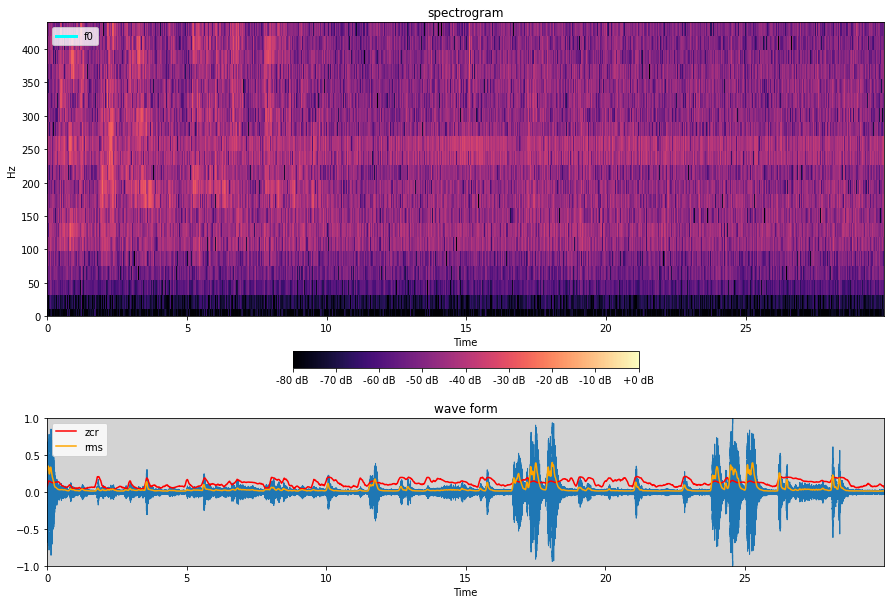

In [13]:
y, sr, phonemes, times, hop_length, f0 = plotter(filename=filename_1, block_size=30, block=56)

### Block sample

In [14]:
ipd.Audio(data=y, rate=sr)

### Phoneme sample

In [5]:
start_idx, end_idx = frames_to_samples(phonemes[0], hop_length)
ipd.Audio(y[start_idx:end_idx]*2, rate=sr, autoplay=True)

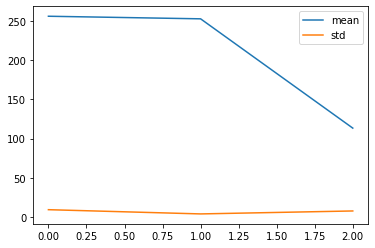

In [6]:
stats = extract_stats(phonemes, times, f0)
sns.lineplot(x=stats['index'], y=stats['mean'], label='mean')
sns.lineplot(x=stats['index'], y=stats['std'], label='std')
plt.show()

## Normal

Sample rate: 44100 Hz
Total duration: 38.57s
Block size: 6s
fmin: 98.00 Hz
fmax: 440.00 Hz
0.067473479811412
Phonemes detected: 14
voiced_ratio: 41.39%


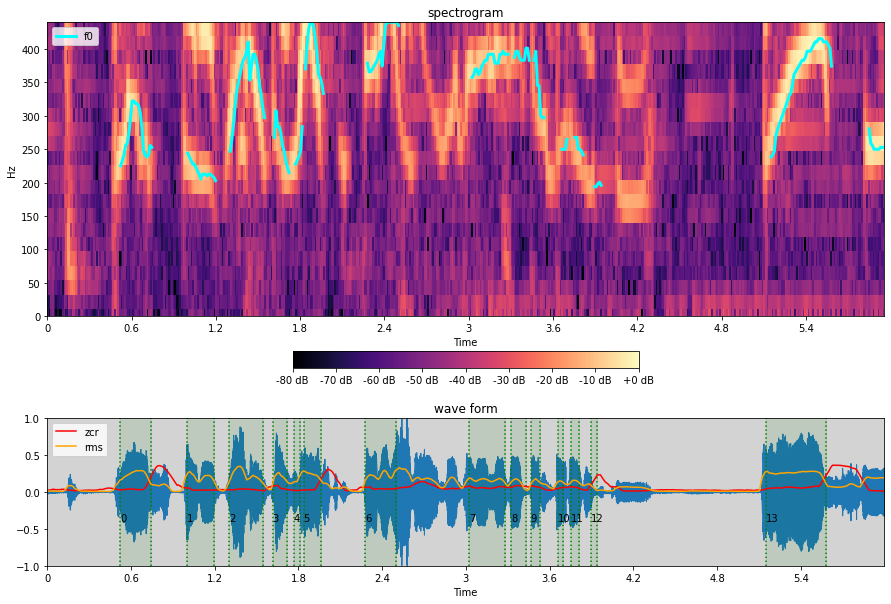

In [15]:
y, sr, phonemes, times, hop_length, f0 = plotter(filename=filename_2, block_size=6, block=2)

### Block sample

In [16]:
ipd.Audio(data=y, rate=sr)

### Phoneme sample

In [9]:
start_idx, end_idx = frames_to_samples(phonemes[0], hop_length)
ipd.Audio(y[start_idx:end_idx]*2, rate=sr, autoplay=True)

IndexError: list index out of range

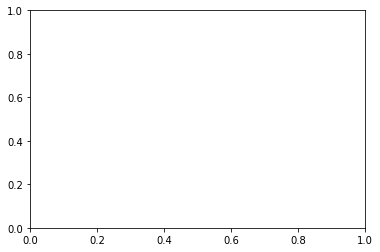

In [10]:
stats = extract_stats(phonemes, times, f0)
sns.lineplot(x=stats['index'], y=stats['mean'], label='mean')
sns.lineplot(x=stats['index'], y=stats['std'], label='std')
plt.show()

# Training

Since monotony is relative to the neighbouring frequencies, like the ones before or after, it is important to make the delta (or the comparator) able to change in accordance to its block.

## Monotone

In [11]:
Algorithm(filename=filename_1, block_size=30).train()

1/84 - No speech detected.
2/84 - voiced_ratio: 22.25 - phonemes: 31 - monotonic_frames: 396 - elapsed_time: 1.29s
3/84 - voiced_ratio: 24.73 - phonemes: 39 - monotonic_frames: 531 - elapsed_time: 1.31s
4/84 - voiced_ratio: 17.69 - phonemes: 25 - monotonic_frames: 371 - elapsed_time: 1.28s
5/84 - voiced_ratio: 23.53 - phonemes: 33 - monotonic_frames: 387 - elapsed_time: 1.25s
6/84 - voiced_ratio: 21.90 - phonemes: 32 - monotonic_frames: 337 - elapsed_time: 1.30s
7/84 - voiced_ratio: 7.66 - phonemes: 9 - monotonic_frames: 176 - elapsed_time: 1.38s
8/84 - voiced_ratio: 22.79 - phonemes: 40 - monotonic_frames: 458 - elapsed_time: 1.27s
9/84 - voiced_ratio: 16.49 - phonemes: 27 - monotonic_frames: 361 - elapsed_time: 1.23s
10/84 - voiced_ratio: 9.71 - phonemes: 16 - monotonic_frames: 223 - elapsed_time: 1.32s
11/84 - voiced_ratio: 21.59 - phonemes: 34 - monotonic_frames: 488 - elapsed_time: 1.17s
12/84 - voiced_ratio: 18.89 - phonemes: 33 - monotonic_frames: 425 - elapsed_time: 1.19s
13/84

## Normal

In [12]:
Algorithm(filename=filename_2, block_size=6).train()

1/6 - voiced_ratio: 36.36 - phonemes: 9 - monotonic_frames: 0 - elapsed_time: 0.27s
2/6 - No speech detected.
3/6 - voiced_ratio: 41.39 - phonemes: 14 - monotonic_frames: 0 - elapsed_time: 0.24s
4/6 - voiced_ratio: 23.79 - phonemes: 13 - monotonic_frames: 10 - elapsed_time: 0.25s
5/6 - voiced_ratio: 26.11 - phonemes: 7 - monotonic_frames: 27 - elapsed_time: 0.25s
6/6 - voiced_ratio: 25.53 - phonemes: 4 - monotonic_frames: 0 - elapsed_time: 0.24s
